# Using Amazon Order History dataset as use case

In [1]:
import kagglehub

# Download latest version
orders_path= kagglehub.dataset_download("isiddharthpatil/e-commerce-product-return-likelihood-dataset")
print("Path to dataset files:", orders_path)

C:\Users\Lenovo\anaconda3\envs\BoWise\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Lenovo\.cache\kagglehub\datasets\isiddharthpatil\e-commerce-product-return-likelihood-dataset\versions\1


In [2]:
import os
folder = r"C:\Users\Lenovo\.cache\kagglehub\datasets\isiddharthpatil\e-commerce-product-return-likelihood-dataset\versions\1"
print(os.listdir(folder))

['amazon_returns_dataset_cleaned.xlsx']


In [3]:
import pandas as pd
df_orders_seed = pd.read_excel(os.path.join(folder, "amazon_returns_dataset_cleaned.xlsx"))

In [4]:
print(df_orders_seed.columns)

Index(['order_id', 'customer_id', 'product_id', 'product_category', 'price',
       'quantity', 'order_datetime', 'order_weekday', 'order_hour',
       'delivery_days', 'shipping_type', 'is_prime_member', 'seller_rating',
       'previous_returns_count', 'customer_tenure_days',
       'customer_total_orders', 'payment_method', 'discount_pct',
       'review_rating', 'return_score', 'returned', 'return_reason'],
      dtype='object')


In [5]:
print(df_orders_seed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                5000 non-null   object        
 1   customer_id             5000 non-null   object        
 2   product_id              5000 non-null   object        
 3   product_category        5000 non-null   object        
 4   price                   5000 non-null   float64       
 5   quantity                5000 non-null   int64         
 6   order_datetime          5000 non-null   datetime64[ns]
 7   order_weekday           5000 non-null   object        
 8   order_hour              5000 non-null   int64         
 9   delivery_days           5000 non-null   int64         
 10  shipping_type           5000 non-null   object        
 11  is_prime_member         5000 non-null   int64         
 12  seller_rating           5000 non-null   float64 

In [6]:
df_orders_seed.to_csv("../data/seed/amazon_transactions_seed.csv", index=False)

# Prepare Dataset to model a CLV prediction model

Handle Missing values

In [7]:
# check missing values
df_orders_seed.isnull().sum()[df_orders_seed.isnull().sum() > 0]

return_reason    2500
dtype: int64

In [8]:
missing_pct = df_orders_seed['return_reason'].isnull().mean() * 100
print(f"{missing_pct:.2f}% missing in 'return_reason'")

50.00% missing in 'return_reason'


In [9]:
#Check whether the missingness is random or related to another feature.
df_orders_seed.groupby('returned')['return_reason'].apply(lambda x: x.isnull().mean() * 100)

returned
0    100.0
1      0.0
Name: return_reason, dtype: float64

In [10]:
# the missing values are due to transaction with no return hence no return reason
df_orders_seed['return_reason'] = df_orders_seed['return_reason'].fillna('No Return')

Cleaning

In [11]:
#fix types

# Convert numeric strings to floats/ints
num_cols = ['price', 'quantity', 'delivery_days', 'seller_rating',
            'previous_returns_count', 'customer_tenure_days',
            'customer_total_orders', 'discount_pct', 'review_rating',
            'return_score']
df_orders_seed[num_cols] = df_orders_seed[num_cols].apply(pd.to_numeric, errors='coerce')

# Convert booleans
df_orders_seed['is_prime_member'] = df_orders_seed['is_prime_member'].astype(int)
df_orders_seed['returned'] = df_orders_seed['returned'].astype(int)

# Convert datetime
df_orders_seed['order_datetime'] = pd.to_datetime(df_orders_seed['order_datetime'], errors='coerce')


Handle outliers

In [12]:
df_orders_seed[num_cols].describe()

,price,quantity,delivery_days,seller_rating,previous_returns_count,customer_tenure_days,customer_total_orders,discount_pct,review_rating,return_score
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,145.728316,1.116600,3.353200,4.003252,0.611600,1998.899200,8.037600,6.891000,3.955600,0.381064
std,182.738809,0.380833,2.049412,0.580645,0.779273,1162.445843,2.825276,8.353626,1.061816,0.152509
min,3.440000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000
25%,46.017500,1.000000,2.000000,3.510000,0.000000,985.500000,6.000000,0.000000,4.000000,0.265725
50%,89.605000,1.000000,3.000000,4.000000,0.000000,2007.000000,8.000000,5.000000,4.000000,0.360850
75%,176.822500,1.000000,4.000000,4.510000,1.000000,3024.500000,10.000000,10.000000,5.000000,0.482025
max,4459.530000,3.000000,10.000000,5.000000,4.000000,3999.000000,19.000000,30.000000,5.000000,1.000000


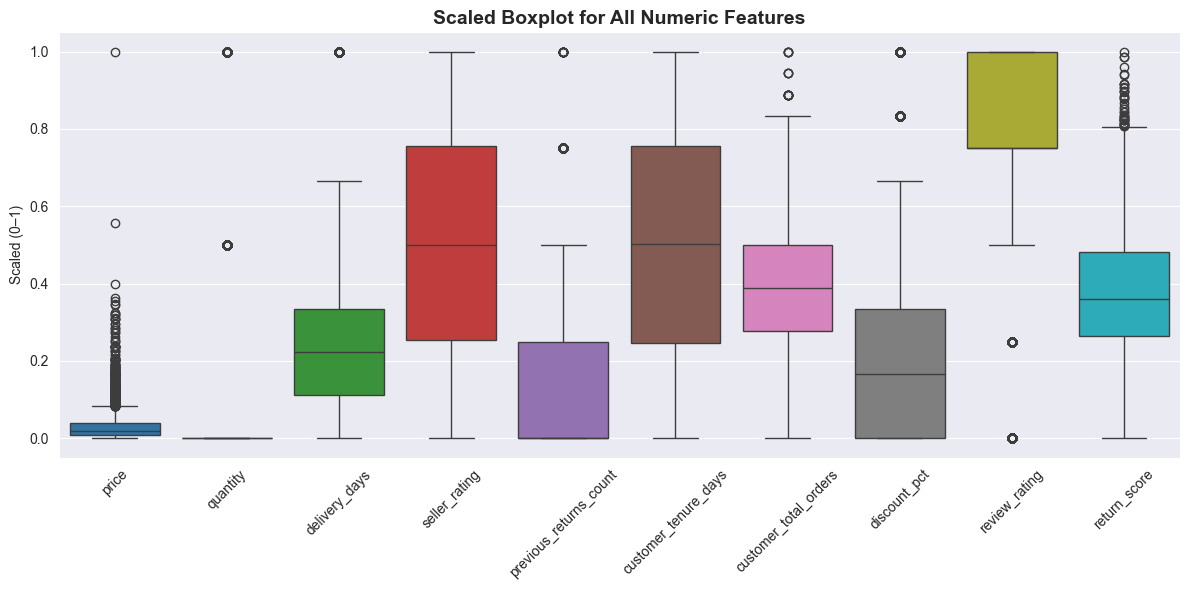

In [13]:
from sklearn.preprocessing import MinMaxScaler
#plot to see outliers
import matplotlib.pyplot as plt
import seaborn as sns

# Scale between 0 and 1
scaler = MinMaxScaler()
df_scaled = df_orders_seed.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

# Plot simple boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled[num_cols])
plt.title("Scaled Boxplot for All Numeric Features", fontsize=14, fontweight='bold')
plt.ylabel("Scaled (0–1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Clip and correct anomalies
df_orders_seed['discount_pct'] = df_orders_seed['discount_pct'].clip(0, 1) * 100
df_orders_seed['price'] = df_orders_seed['price'].clip(0, 1500)
df_orders_seed['review_rating'] = df_orders_seed['review_rating'].clip(1, 5)
df_orders_seed['delivery_days'] = df_orders_seed['delivery_days'].clip(0, 15)

In [15]:
#check for duplicates
df_orders_seed.columns[df_orders_seed.columns.duplicated()]

Index([], dtype='object')

In [16]:
# compute monetary value
df_orders_seed['discount_pct'] = df_orders_seed['discount_pct'].clip(0, 1)
df_orders_seed['order_value'] = (
        df_orders_seed['price'] *
        df_orders_seed['quantity'] *
        (1 - df_orders_seed['discount_pct'])
)

In [17]:
#Aggregate per customer to summarize customer-level behavior and value metrics.

# Ensure discount is fractional
df_orders_seed['discount_pct'] = df_orders_seed['discount_pct'] / 100

# Aggregate per customer
customer_transaction_df = df_orders_seed.groupby('customer_id').agg(
    total_spent=('order_value', 'sum'),
    avg_order_value=('order_value', 'mean'),
    total_orders=('order_id', 'nunique'),
    total_items=('quantity', 'sum'),
    avg_discount=('discount_pct', 'mean'),
    avg_review_rating=('review_rating', 'mean'),
    avg_seller_rating=('seller_rating', 'mean'),
    avg_delivery_days=('delivery_days', 'mean'),
    total_returns=('returned', 'sum'),
    return_ratio=('returned', 'mean'),
    total_previous_returns=('previous_returns_count', 'sum'),
    is_prime_member=('is_prime_member', 'max'),
    customer_tenure_days=('customer_tenure_days', 'max'),
    last_order_date=('order_datetime', 'max'),
    first_order_date=('order_datetime', 'min')
).reset_index()


In [18]:
import pandas as pd

# Reference date: 1 day after the most recent order
reference_date = pd.Timestamp(df_orders_seed['order_datetime'].max()) + pd.Timedelta(days=1)

# Ensure proper datetime format
customer_transaction_df['last_order_date'] = pd.to_datetime(customer_transaction_df['last_order_date'], errors='coerce')
customer_transaction_df['first_order_date'] = pd.to_datetime(customer_transaction_df['first_order_date'], errors='coerce')

# Compute RFM-style metrics
customer_transaction_df['recency_days'] = (reference_date - customer_transaction_df['last_order_date']).dt.days
customer_transaction_df['tenure_days'] = (
        customer_transaction_df['last_order_date'] -
        customer_transaction_df['first_order_date']
).dt.days
customer_transaction_df['tenure_days'] = customer_transaction_df['tenure_days'].replace(0, 1)

# Frequency (orders per 30 days)
customer_transaction_df['frequency'] = (
    customer_transaction_df['total_orders'] /
    customer_transaction_df['tenure_days']
) * 30


In [19]:
print(customer_transaction_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             2447 non-null   object        
 1   total_spent             2447 non-null   float64       
 2   avg_order_value         2447 non-null   float64       
 3   total_orders            2447 non-null   int64         
 4   total_items             2447 non-null   int64         
 5   avg_discount            2447 non-null   float64       
 6   avg_review_rating       2447 non-null   float64       
 7   avg_seller_rating       2447 non-null   float64       
 8   avg_delivery_days       2447 non-null   float64       
 9   total_returns           2447 non-null   int64         
 10  return_ratio            2447 non-null   float64       
 11  total_previous_returns  2447 non-null   int64         
 12  is_prime_member         2447 non-null   int64   

In [20]:
print(customer_transaction_df.shape)
customer_transaction_df.head()

(2447, 19)


,customer_id,total_spent,avg_order_value,total_orders,total_items,avg_discount,avg_review_rating,avg_seller_rating,avg_delivery_days,total_returns,return_ratio,total_previous_returns,is_prime_member,customer_tenure_days,last_order_date,first_order_date,recency_days,tenure_days,frequency
0,C10000,58.88,29.440,2,2,0.005,5.0,4.145,1.0,0,0.0,1,1,2397,2025-08-06 14:00:00,2024-05-19 18:00:00,17,443,0.135440
1,C10004,118.49,59.245,2,2,0.000,1.0,4.290,4.0,1,0.5,0,1,3440,2024-09-19 17:00:00,2024-06-02 06:00:00,338,109,0.550459
2,C10005,30.46,15.230,2,2,0.005,5.0,4.160,5.0,0,0.0,0,1,2572,2025-07-26 02:00:00,2025-03-01 20:00:00,28,146,0.410959
3,C10006,0.00,0.000,1,1,0.010,4.0,4.210,4.0,1,1.0,1,1,2469,2025-05-02 00:00:00,2025-05-02 00:00:00,113,1,30.000000
4,C10007,154.50,154.500,1,1,0.000,3.0,3.360,3.0,0,0.0,0,0,1618,2024-06-13 02:00:00,2024-06-13 02:00:00,436,1,30.000000


In [21]:
customer_transaction_df.to_csv("../data/processed/transactions.csv", index=False)